In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.io.json import json_normalize
import scipy.stats as stats
import pylab
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
%matplotlib inline

In [263]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [264]:
print(train.shape)
print(test.shape)

(10886, 12)
(6493, 9)


In [265]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [266]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [267]:
def generateColumnInfo(df):
    cls = []
    nullCount = []
    nonNullCount = []
    nullsPct = []
    uniqCount = []
    dataType = []
    for i,col in enumerate(df.columns):
        cls.append(col)
        nullCount.append(df[col].isnull().sum())
        nonNullCount.append(len(df)-df[col].isnull().sum())
        nullsPct.append((df[col].isnull().sum())*(100)/len(df))
        uniqCount.append(df[col].nunique())
        dataType.append(df[col].dtype)
        
    column_info = pd.DataFrame(
        {'ColumnName': cls,
         'NullCount': nullCount,
         'NonNullCount': nonNullCount,
         'NullPercent': nullsPct,
         'UniqueValueCount': uniqCount,
         'DataType':dataType
        })
    return(column_info)

In [268]:
generateColumnInfo(train)

,ColumnName,NullCount,NonNullCount,NullPercent,UniqueValueCount,DataType
0,datetime,0,10886,0.0,10886,object
1,season,0,10886,0.0,4,int64
2,holiday,0,10886,0.0,2,int64
3,workingday,0,10886,0.0,2,int64
4,weather,0,10886,0.0,4,int64
5,temp,0,10886,0.0,49,float64
6,atemp,0,10886,0.0,60,float64
7,humidity,0,10886,0.0,89,int64
8,windspeed,0,10886,0.0,28,float64
9,casual,0,10886,0.0,309,int64


In [269]:
generateColumnInfo(test)

,ColumnName,NullCount,NonNullCount,NullPercent,UniqueValueCount,DataType
0,datetime,0,6493,0.0,6493,object
1,season,0,6493,0.0,4,int64
2,holiday,0,6493,0.0,2,int64
3,workingday,0,6493,0.0,2,int64
4,weather,0,6493,0.0,4,int64
5,temp,0,6493,0.0,49,float64
6,atemp,0,6493,0.0,65,float64
7,humidity,0,6493,0.0,79,int64
8,windspeed,0,6493,0.0,27,float64


Train contains 3 additional columns : casual, registered and count. There are no null values. We will startby converting the column "datetime" to datetime type. We will extract the date related columns and drop the original column. 

In [270]:
train['date'] = pd.to_datetime(train['datetime'],format='%Y-%m-%d')
train.drop(['datetime'],axis=1,inplace=True)
train['date_year'],train['date_month'],train['date_day'],train['date_weekday'],train['date_hour']  = train['date'].dt.year,train['date'].dt.month,train['date'].dt.day,train['date'].dt.weekday,train['date'].dt.hour
train['weekday_name'] = train['date'].dt.weekday_name

test['date'] = pd.to_datetime(test['datetime'],format='%Y-%m-%d')
#test.drop(['datetime'],axis=1,inplace=True)
test['date_year'],test['date_month'],test['date_day'],test['date_weekday'],test['date_hour']  = test['date'].dt.year,test['date'].dt.month,test['date'].dt.day,test['date'].dt.weekday,test['date'].dt.hour

In [271]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,date_year,date_month,date_day,date_weekday,date_hour,weekday_name
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01 00:00:00,2011,1,1,5,0,Saturday
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011-01-01 01:00:00,2011,1,1,5,1,Saturday
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011-01-01 02:00:00,2011,1,1,5,2,Saturday
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011-01-01 03:00:00,2011,1,1,5,3,Saturday
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011-01-01 04:00:00,2011,1,1,5,4,Saturday


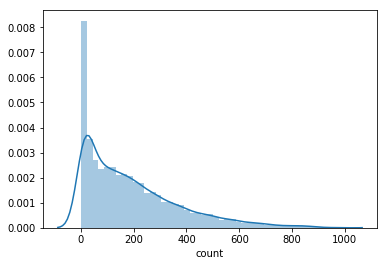

In [272]:
sns.distplot(train['count'])

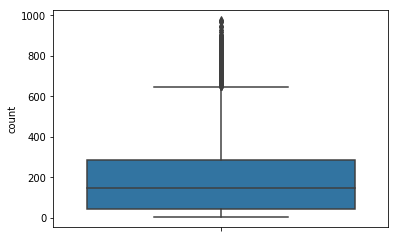

In [273]:
sns.boxplot(train['count'],orient='v')

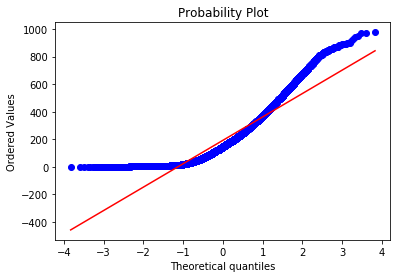

In [274]:
measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(train['count'], dist="norm", plot=pylab)
pylab.show()

In [275]:
#Shapiro–Wilk test
stat, p = shapiro(train['count'])
print('p=%.3f' % (p)) #Normal if p>0.1

p=0.000


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## EDA

In [276]:
#creating additional dataframe for EDA
byUserType = train.drop(['count'],axis=1)
byUserType = pd.melt(byUserType,id_vars = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'date',
       'date_year', 'date_month', 'date_day', 'date_weekday', 'date_hour',
       'weekday_name'],value_vars = ['casual', 'registered'],var_name='user_type',value_name='user_count')

### Date Columns

We will analyze each column in this section.

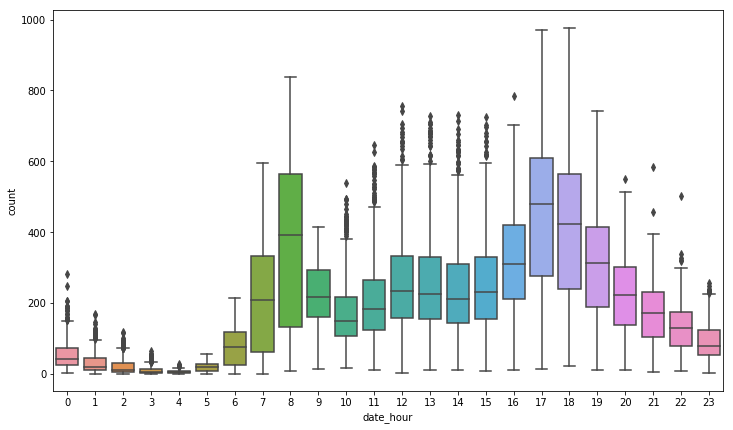

In [277]:
plt.figure(figsize=(12,7))
sns.boxplot(data=train, x='date_hour',y='count')
plt.title('')
plt.show()

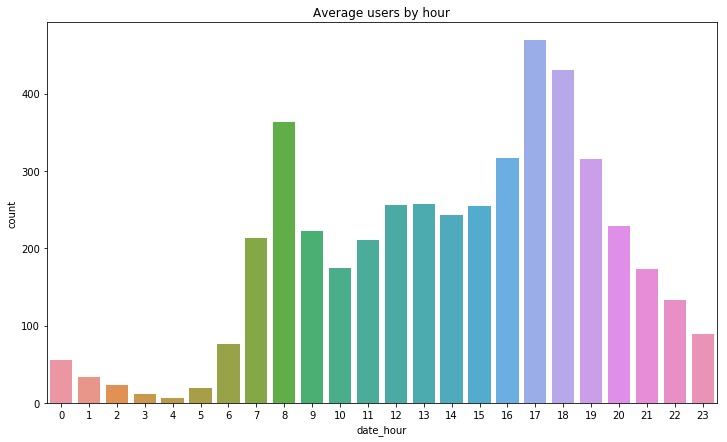

In [278]:
plt.figure(figsize=(12,7))
sns.barplot(data=train,x='date_hour',y='count',ci=None)
plt.title('Average users by hour')
plt.show()

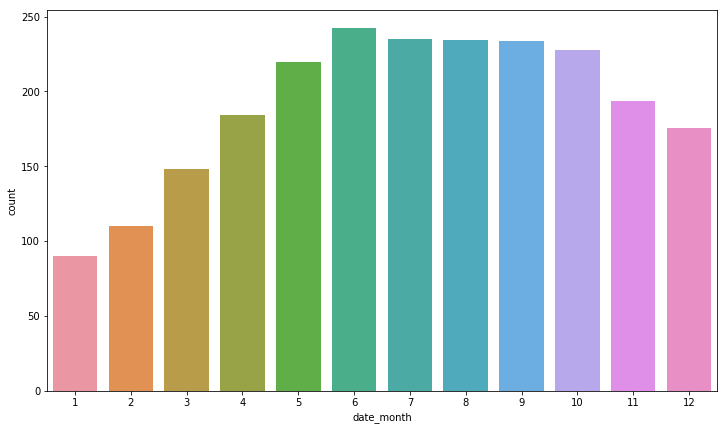

In [279]:
plt.figure(figsize=(12,7))
sns.barplot(data=train,x='date_month',y='count',ci=None)
plt.title('')
plt.show()

Text(0.5,1,'Average users by hour and user type')

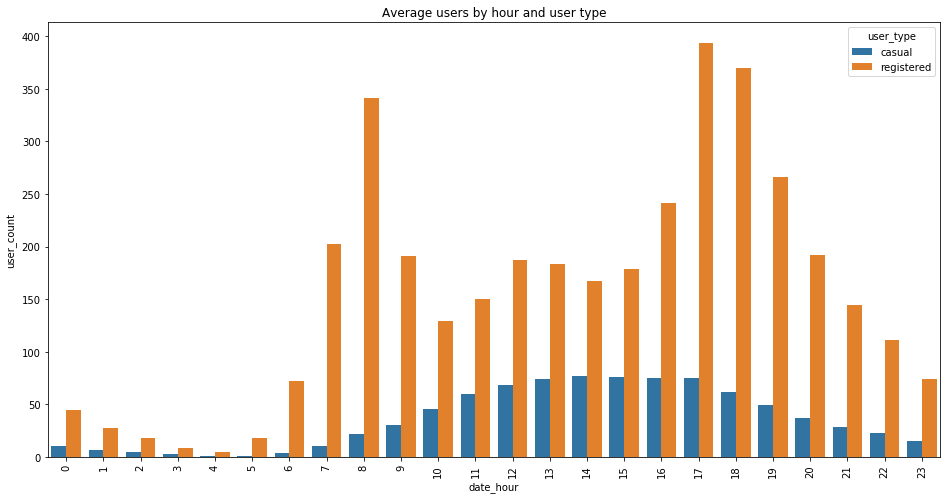

In [280]:
plt.figure(figsize=(16,8))
plt.xticks(rotation=90)
ax = sns.barplot(data=byUserType,x='date_hour',y='user_count',hue='user_type',ci=None)
plt.title('Average users by hour and user type')

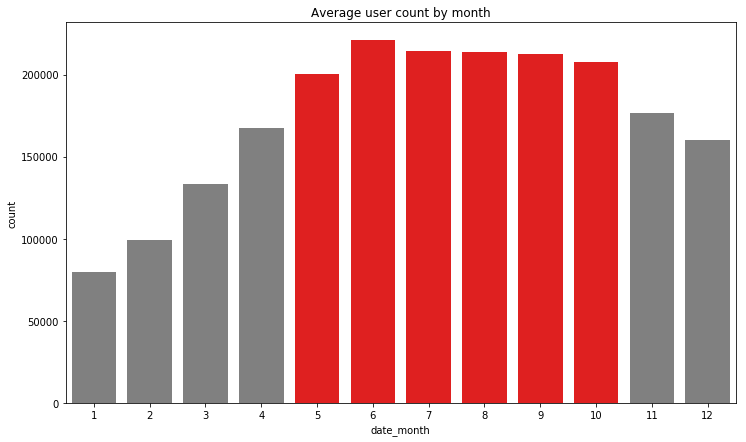

In [281]:
countByMonth = train.groupby(['date_month'],as_index=False).sum()[['date_month','count']]
ids = countByMonth['date_month']
values = countByMonth['count']
plt.figure(figsize=(12,7))
clrs = ['grey' if (x < 180000) else 'red' for x in values ]
sns.barplot(x=ids,y=values,ci=None,palette=clrs)
plt.title('Average user count by month')
plt.show()

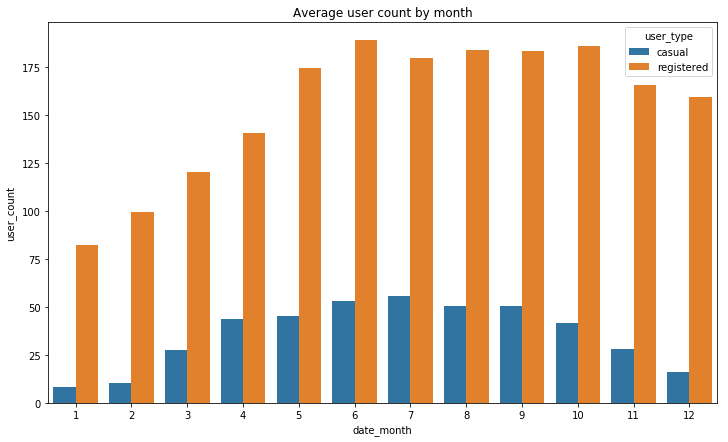

In [282]:
plt.figure(figsize=(12,7))
sns.barplot(data=byUserType,x='date_month',y='user_count',hue='user_type',ci=None)
plt.title('Average user count by month')
plt.show()

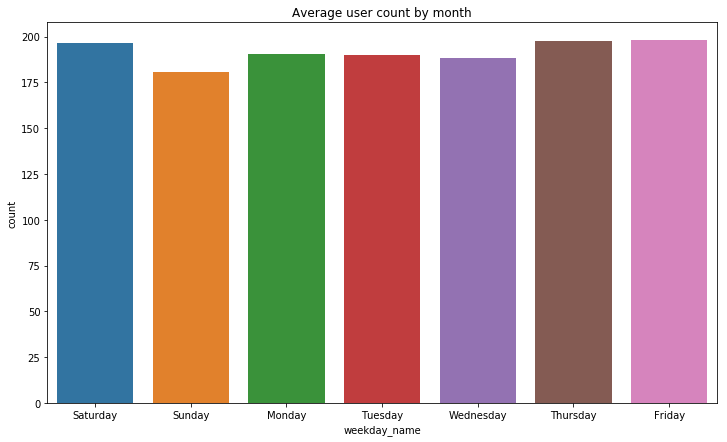

In [283]:
plt.figure(figsize=(12,7))
sns.barplot(data=train,x='weekday_name',y='count',ci=None)
plt.title('Average user count by month')
plt.show()

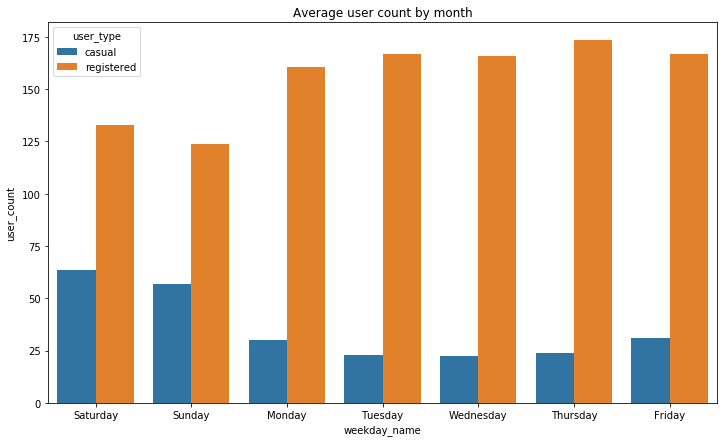

In [284]:
plt.figure(figsize=(12,7))
sns.barplot(data=byUserType,x='weekday_name',y='user_count',hue='user_type',ci=None)
plt.title('Average user count by month')
plt.show()

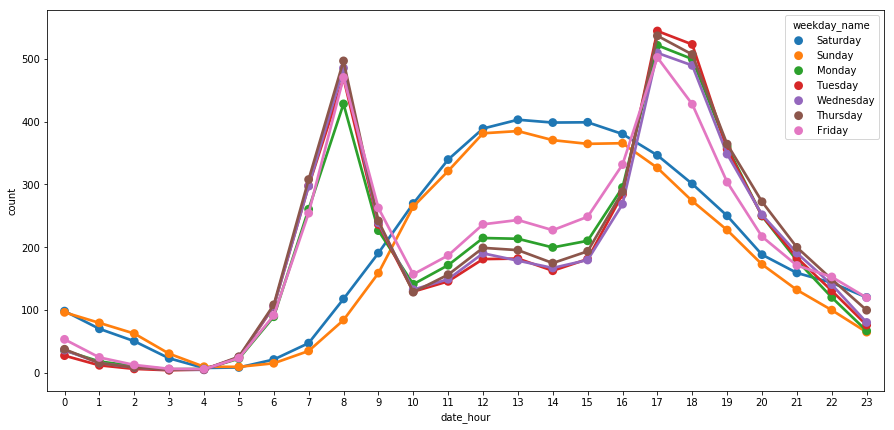

In [285]:
plt.figure(figsize=(15,7))
sns.pointplot(data=train,x='date_hour',y='count',hue='weekday_name',ci=None)
plt.title('')
plt.show()

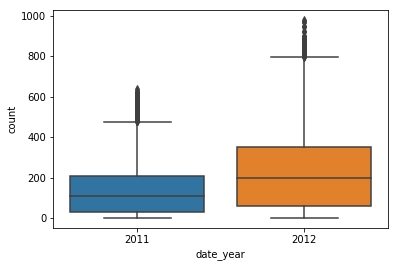

In [286]:
sns.boxplot(data=train,x='date_year',y='count')

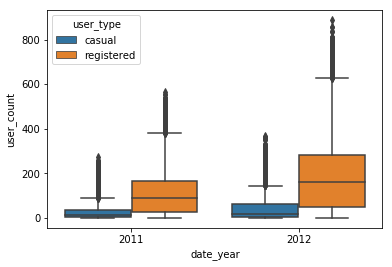

In [287]:
sns.boxplot(data=byUserType,x='date_year',y='user_count',hue="user_type")

### Season

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


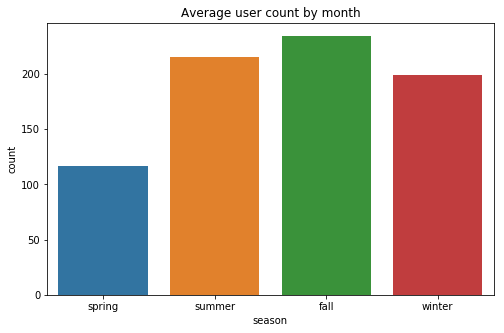

In [288]:
plt.figure(figsize=(8,5))
sns.barplot(data=train,x='season',y='count',ci=None)
plt.title('Average user count by month')
ax = plt.axes()
plt.xticks(rotation=0)
ax.set_xticklabels(['spring','summer','fall','winter'])
plt.show()

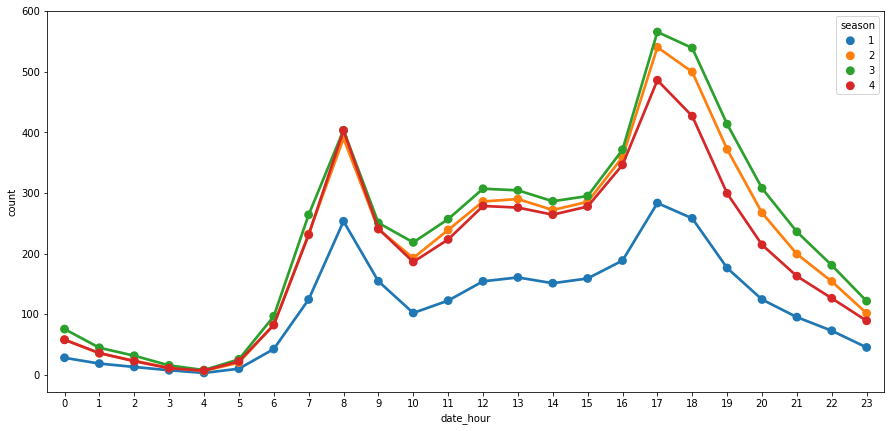

In [289]:
plt.figure(figsize=(15,7))
g = sns.pointplot(data=train,x='date_hour',y='count',hue='season',ci=None)
plt.title('')
plt.show()

### Holiday and Working Days

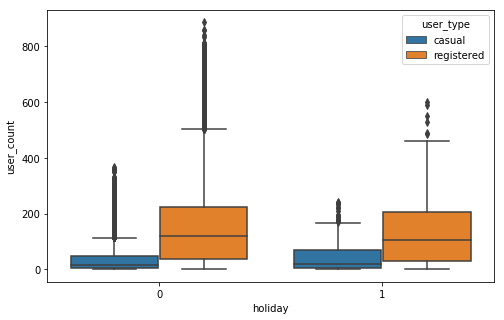

In [290]:
plt.figure(figsize=(8,5))
sns.boxplot(data=byUserType,x='holiday',y='user_count',hue='user_type')
plt.title('')
plt.show()

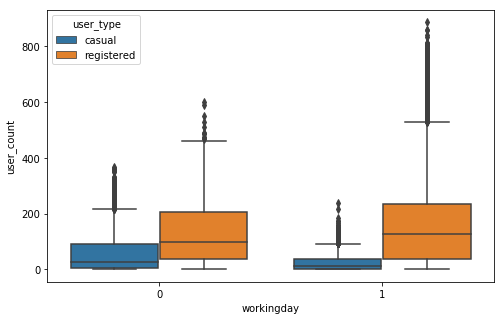

In [291]:
plt.figure(figsize=(8,5))
sns.boxplot(data=byUserType,x='workingday',y='user_count',hue='user_type')
plt.title('')
plt.show()

### Weather

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


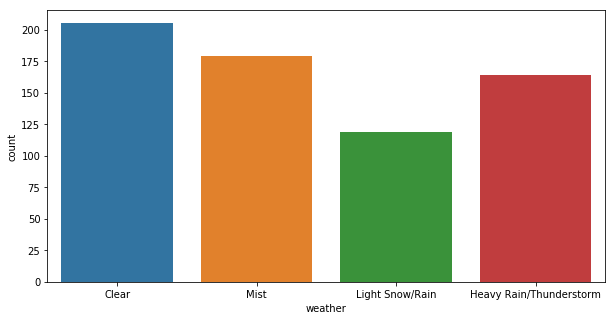

In [292]:
plt.figure(figsize=(10,5))
sns.barplot(data=train,x='weather',y='count',ci=None)
plt.title('')
ax = plt.axes()
plt.xticks(rotation=0)
ax.set_xticklabels(['Clear','Mist','Light Snow/Rain','Heavy Rain/Thunderstorm'])
plt.show()

### Temp

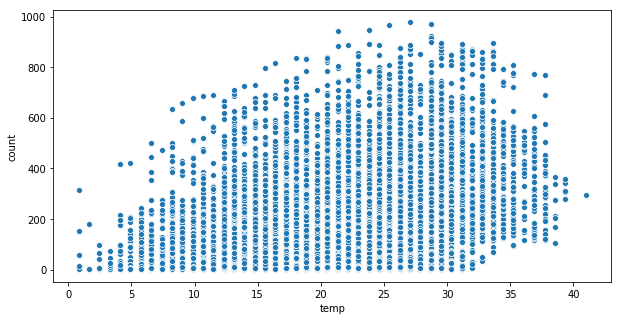

In [293]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=train,x='temp',y='count',ci=None)
plt.title('')
plt.show()

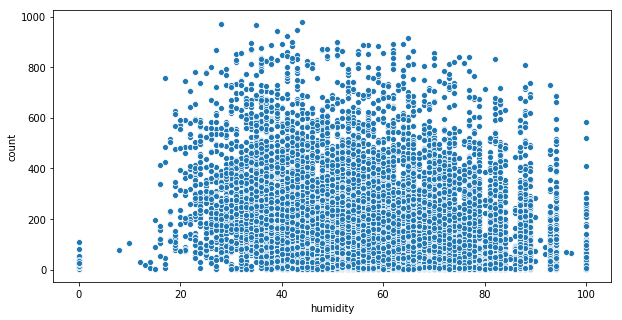

In [294]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=train,x='humidity',y='count',ci=None)
plt.title('')
plt.show()

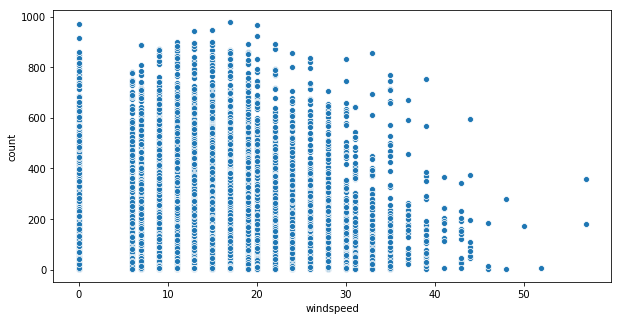

In [295]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=train,x='windspeed',y='count',ci=None)
plt.title('')
plt.show()

In [296]:
train.drop(['weekday_name'],inplace=True,axis=1)

## Feature Engineering

In [297]:
generateColumnInfo(train)

,ColumnName,NullCount,NonNullCount,NullPercent,UniqueValueCount,DataType
0,season,0,10886,0.0,4,int64
1,holiday,0,10886,0.0,2,int64
2,workingday,0,10886,0.0,2,int64
3,weather,0,10886,0.0,4,int64
4,temp,0,10886,0.0,49,float64
5,atemp,0,10886,0.0,60,float64
6,humidity,0,10886,0.0,89,int64
7,windspeed,0,10886,0.0,28,float64
8,casual,0,10886,0.0,309,int64
9,registered,0,10886,0.0,731,int64


In [298]:
generateColumnInfo(test)

,ColumnName,NullCount,NonNullCount,NullPercent,UniqueValueCount,DataType
0,datetime,0,6493,0.0,6493,object
1,season,0,6493,0.0,4,int64
2,holiday,0,6493,0.0,2,int64
3,workingday,0,6493,0.0,2,int64
4,weather,0,6493,0.0,4,int64
5,temp,0,6493,0.0,49,float64
6,atemp,0,6493,0.0,65,float64
7,humidity,0,6493,0.0,79,int64
8,windspeed,0,6493,0.0,27,float64
9,date,0,6493,0.0,6493,datetime64[ns]


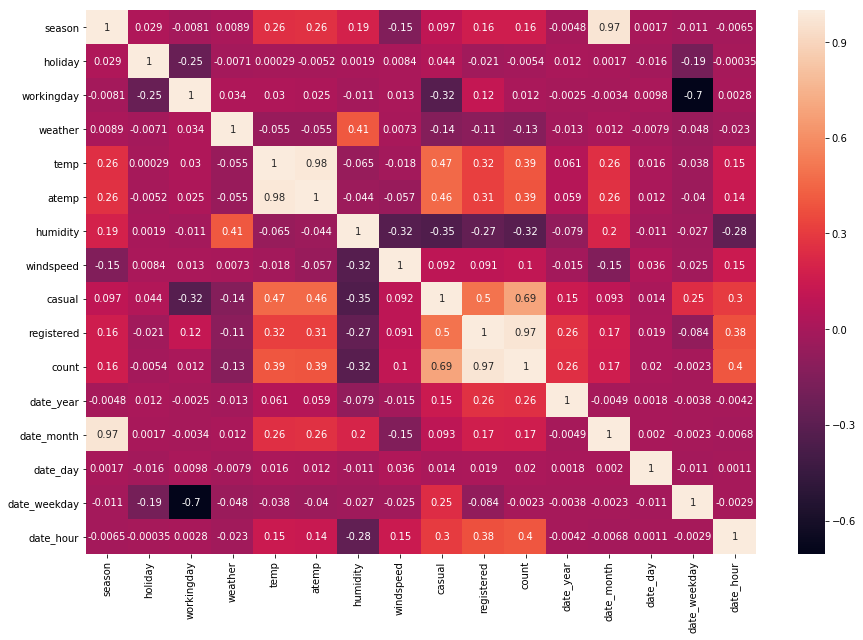

In [299]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(),annot=True)
plt.show()

We see very high co-relation between season and date_month and temp and atemp. We will drop season and atemp

In [300]:
train.drop(['season','atemp'],inplace=True,axis=1)
test.drop(['season','atemp'],inplace=True,axis=1)

In [301]:
train = pd.get_dummies(train, columns=['weather'], prefix=['weather_'])

In [302]:
test = pd.get_dummies(test, columns=['weather'], prefix=['weather_'])

In [303]:
train.drop('date',inplace=True,axis=1)
test.drop('date',inplace=True,axis=1)

In [304]:
train.columns

Index(['holiday', 'workingday', 'temp', 'humidity', 'windspeed', 'casual',
       'registered', 'count', 'date_year', 'date_month', 'date_day',
       'date_weekday', 'date_hour', 'weather__1', 'weather__2', 'weather__3',
       'weather__4'],
      dtype='object')

In [305]:
test.columns

Index(['datetime', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'date_year', 'date_month', 'date_day', 'date_weekday', 'date_hour',
       'weather__1', 'weather__2', 'weather__3', 'weather__4'],
      dtype='object')

In [306]:
generateColumnInfo(train)

,ColumnName,NullCount,NonNullCount,NullPercent,UniqueValueCount,DataType
0,holiday,0,10886,0.0,2,int64
1,workingday,0,10886,0.0,2,int64
2,temp,0,10886,0.0,49,float64
3,humidity,0,10886,0.0,89,int64
4,windspeed,0,10886,0.0,28,float64
5,casual,0,10886,0.0,309,int64
6,registered,0,10886,0.0,731,int64
7,count,0,10886,0.0,822,int64
8,date_year,0,10886,0.0,2,int64
9,date_month,0,10886,0.0,12,int64


In [307]:
train['date_year'] = train['date_year'].astype("category")
train['date_month'] = train['date_month'].astype("category")
train['date_day'] = train['date_day'].astype("category")
train['date_weekday'] = train['date_weekday'].astype("category")
train['date_hour'] = train['date_hour'].astype("category")

In [308]:
generateColumnInfo(train)

,ColumnName,NullCount,NonNullCount,NullPercent,UniqueValueCount,DataType
0,holiday,0,10886,0.0,2,int64
1,workingday,0,10886,0.0,2,int64
2,temp,0,10886,0.0,49,float64
3,humidity,0,10886,0.0,89,int64
4,windspeed,0,10886,0.0,28,float64
5,casual,0,10886,0.0,309,int64
6,registered,0,10886,0.0,731,int64
7,count,0,10886,0.0,822,int64
8,date_year,0,10886,0.0,2,category
9,date_month,0,10886,0.0,12,category


## Modeling

In [309]:
X = train.drop(['count','casual','registered'],axis=1)
y = train['count']

In [310]:
X_train,X_valid, y_train,y_valid = train_test_split(X,y, test_size=0.3,random_state=100)

In [312]:
res_alg = ['Random Forest','SVR','KNN','GBR','LR']
res_rmsle = []

In [313]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

In [314]:
rfModel2 = RandomForestRegressor(n_estimators=100)
rfModel2.fit(X_train,np.log1p(y_train))
rfPred2 = rfModel2.predict(X_valid)
np.sqrt(mean_squared_log_error(np.exp(rfPred2),y_valid))
#print("RMSLE value for ")
res_rmsle.append(np.sqrt(mean_squared_log_error(np.exp(rfPred2),y_valid)))

In [315]:
svrModel = SVR()
svrModel.fit(X_train,np.log1p(y_train))
svrPred = svrModel.predict(X_valid)
#np.sqrt(mean_squared_log_error(np.exp(svrPred),y_valid))
res_rmsle.append(np.sqrt(mean_squared_log_error(np.exp(svrPred),y_valid)))

In [316]:
knnModel2 = KNeighborsRegressor()
knnModel2.fit(X_train,np.log1p(y_train))
knnPred2 = knnModel2.predict(X_valid)
#np.sqrt(mean_squared_log_error(np.exp(knnPred2),y_valid))
res_rmsle.append(mean_squared_log_error(np.exp(knnPred2),y_valid))

In [317]:
gbModel = GradientBoostingRegressor()
gbModel.fit(X_train,np.log1p(y_train))
gbPred = gbModel.predict(X_valid)
gbPred = pd.DataFrame(gbPred)
gbPred = gbPred[0].apply(lambda x:0.0 if x<0 else x)
#np.sqrt(mean_squared_log_error(np.exp(gbPred),y_valid))
res_rmsle.append(np.sqrt(mean_squared_log_error(np.exp(gbPred),y_valid)))

In [318]:
lrModel = LinearRegression()
lrModel.fit(X_train,np.log1p(y_train))
lrPred = lrModel.predict(X_valid)
lrPred = pd.DataFrame(lrPred)
lrPred = lrPred[0].apply(lambda x:0.0 if x<0 else x)
#np.sqrt(mean_squared_log_error(np.exp(lrPred),y_valid))
res_rmsle.append(np.sqrt(mean_squared_log_error(np.exp(lrPred),y_valid)))

In [319]:
results = pd.DataFrame({'Algorithm':res_alg,'RMSLE':res_rmsle})
results.sort_values('RMSLE')

,Algorithm,RMSLE
0,Random Forest,0.318781
3,GBR,0.405260
2,KNN,0.691466
1,SVR,0.942840
4,LR,1.011953


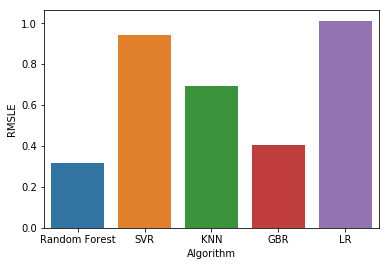

In [320]:
sns.barplot(data=results,x='Algorithm',y='RMSLE')

## Tuning

### Random Search

In [142]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [143]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [144]:
from sklearn.model_selection import RandomizedSearchCV

In [145]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring='neg_mean_squared_log_error')

In [146]:
rf_random.fit(X_train,np.log1p(y_train))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.6min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_log_error',
          verbose=2)

In [147]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

### Grid Search CV

In [321]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [120],
    'max_features': ['auto'],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [1000 ]
}

In [322]:
from sklearn.model_selection import GridSearchCV

In [323]:
rf = RandomForestRegressor()
rf_grid = GridSearchCV(estimator =rf,param_grid=param_grid,scoring='neg_mean_squared_log_error',verbose=2,cv=3)

In [324]:
rf_grid.fit(X_train,np.log1p(y_train))
pred=rf_grid.predict(X_valid)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  15.9s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s remaining:    0.0s


[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  16.1s
[CV] bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000 
[CV]  bootstrap=True, max_depth=120, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000, total=  15.9s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.8s finished


In [325]:
print((np.sqrt(mean_squared_log_error(np.exp(pred),y_valid))))

0.3169078571942545


In [326]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 120,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [328]:
rf_grid.best_estimator_.feature_importances_

array([0.00145947, 0.03511032, 0.05795088, 0.01974989, 0.00868784,
       0.03297761, 0.04034861, 0.00890004, 0.03150256, 0.75304816,
       0.00125483, 0.00086583, 0.00814396, 0.        ])

In [329]:
imp = pd.DataFrame({'Feature':X_train.columns,'Importance':rf_grid.best_estimator_.feature_importances_})

In [330]:
imp.sort_values(by='Importance',ascending=False)

,Feature,Importance
9,date_hour,0.753048
2,temp,0.057951
6,date_month,0.040349
1,workingday,0.035110
5,date_year,0.032978
8,date_weekday,0.031503
3,humidity,0.019750
7,date_day,0.008900
4,windspeed,0.008688
12,weather__3,0.008144


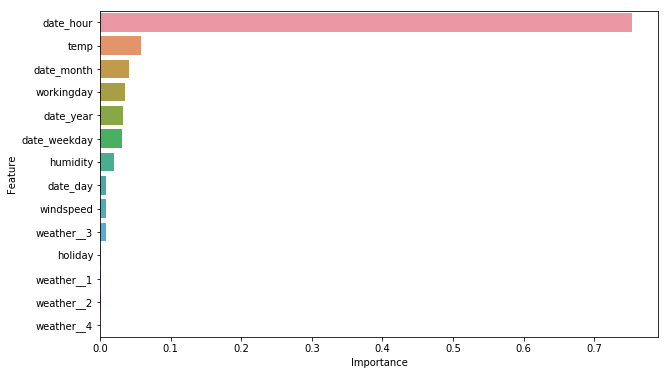

In [331]:
plt.figure(figsize=(10,6))
sns.barplot(data=imp.sort_values(by='Importance',ascending=False),x='Importance',y='Feature')

## Generate predictions for Test

In [332]:
test.columns

Index(['datetime', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'date_year', 'date_month', 'date_day', 'date_weekday', 'date_hour',
       'weather__1', 'weather__2', 'weather__3', 'weather__4'],
      dtype='object')

In [339]:
tPred=rf_grid.predict(test.drop('datetime',axis=1))
tPred = np.exp(tPred)
d={'datetime':test['datetime'],'count':tPred}
ans=pd.DataFrame(d)
ans.to_csv('answer.csv',index=False) # saving to a csv file for predictions on kaggle.